In [58]:
import os
import pandas as pd
import s3fs
import zipfile
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [21]:
DATASET_PATH = "../data/LivingRoom_preprocessed_hack"

## Download Dataset

In [22]:
# Create filesystem object
S3_ENDPOINT_URL = "https://" + os.environ["AWS_S3_ENDPOINT"]
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': S3_ENDPOINT_URL})

In [23]:
# Lister les challenges
fs.ls("gvimont/diffusion/hackathon-minarm-2024")

['gvimont/diffusion/hackathon-minarm-2024/AIVSAI',
 'gvimont/diffusion/hackathon-minarm-2024/Acoustique',
 'gvimont/diffusion/hackathon-minarm-2024/Similarité']

In [24]:
# Lister les fichiers d'un challenge
fs.ls("gvimont/diffusion/hackathon-minarm-2024/Acoustique")

['gvimont/diffusion/hackathon-minarm-2024/Acoustique/LivingRoom_preprocessed_hack.zip']

In [25]:
# Télécharger les données dans le service
PATH_IN = 'gvimont/diffusion/hackathon-minarm-2024/Acoustique/LivingRoom_preprocessed_hack.zip'
fs.download(PATH_IN, 'data/LivingRoom_preprocessed_hack.zip')

KeyboardInterrupt: 

In [ ]:
# Décompresser les données
with zipfile.ZipFile("data/LivingRoom_preprocessed_hack.zip","r") as zip_file:
    zip_file.extractall("data/")

## Read Data

In [ ]:
centroids = np.load(DATASET_PATH + "/Human1/centroid.npy")
deconvoled_trim = np.load(DATASET_PATH + "/Human1/deconvoled_trim.npy")
#skeletons = np.load(DATASET_PATH + "/Human1/skeletons.npy")



In [38]:
centroids_humain2 = np.load(DATASET_PATH + "/Human2/centroid.npy")
deconvoled_trim_humain2 = np.load(DATASET_PATH + "/Human2/deconvoled_trim.npy")
#skeletons = np.load(DATASET_PATH + "/Human1/skeletons.npy")



In [41]:
#print("Skeletons Shape: ", skeletons.shape)
print("Deconvoled Trim Shape humain 1: ", deconvoled_trim.shape)
print("Centroids Shape humain 1: ", centroids.shape)


Deconvoled Trim Shape humain 1:  (1000, 4, 667200)
Centroids Shape humain 1:  (1000, 2)


In [40]:
#print("Skeletons Shape: ", skeletons.shape)
print("Deconvoled Trim Shape humain 2: ", deconvoled_trim_humain2.shape)
print("Centroids Shape humain 2: ", centroids_humain2.shape)


Deconvoled Trim Shape humain 2:  (104, 4, 667200)
Centroids Shape humain 2:  (104, 2)


In [42]:
#Creation et analyse préliminaire des coordonnées
df_centroid_humain1 = pd.DataFrame(centroids, columns=['x', 'y'])



In [50]:
#Creation et analyse préliminaire des coordonnées
df_centroid_humain2 = pd.DataFrame(centroids_humain2, columns=['x', 'y'])



In [ ]:
deconvoled_trim[0][0]



array([9.0724034e-06, 1.7125743e-05, 1.2259779e-05, ..., 8.8617862e-06,
       1.4068604e-05, 1.0661663e-05], dtype=float32)

## Visualize Data

In [57]:
print("Description de Humain 1 :\n",df_centroid_humain1.describe())
print("Description de Humain 2 :\n",df_centroid_humain2.describe())

Description de Humain 1 :
                  x            y
count  1000.000000  1000.000000
mean  -1951.874645  -975.494269
std    1063.168357  1408.316313
min   -4058.242136 -3499.887676
25%   -2793.916664 -2444.690376
50%   -2057.874270  -839.081832
75%   -1021.706420   268.779611
max      56.834894  1542.259690
Description de Humain 2 :
                  x            y
count   104.000000   104.000000
mean  -2091.081613  -837.472064
std    1115.778928  1147.811987
min   -4212.455241 -3050.124740
25%   -3008.410329 -1487.150522
50%   -2243.877343  -884.802815
75%   -1175.886278    20.876289
max     -13.170370  1256.133175


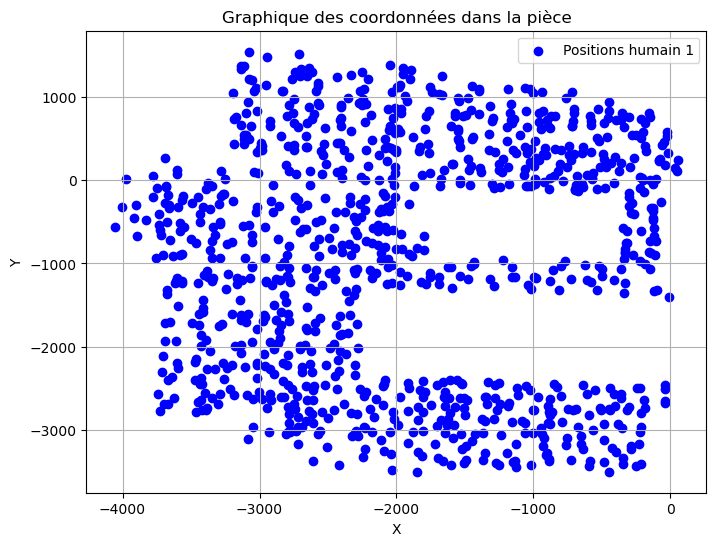

In [51]:
#HUMAIN 1
if 'y' in df_centroid_humain1.columns:
    plt.figure(figsize=(8, 6))
    plt.scatter(df_centroid_humain1['x'], df_centroid_humain1['y'], color='blue', label='Positions humain 1')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Graphique des coordonnées dans la pièce')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("La colonne 'y' n'existe pas dans le DataFrame.")

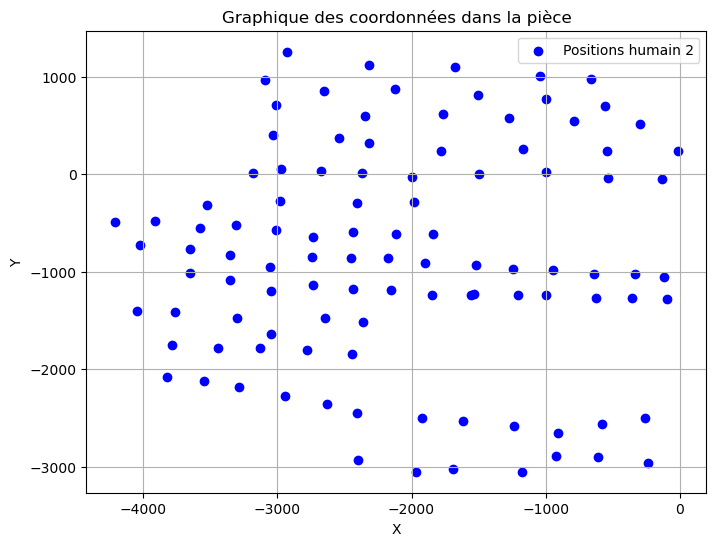

In [52]:
#HUMAIN 2

if 'y' in df_centroid_humain2.columns:
    plt.figure(figsize=(8, 6))
    plt.scatter(df_centroid_humain2['x'], df_centroid_humain2['y'], color='blue', label='Positions humain 2')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Graphique des coordonnées dans la pièce')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("La colonne 'y' n'existe pas dans le DataFrame.")

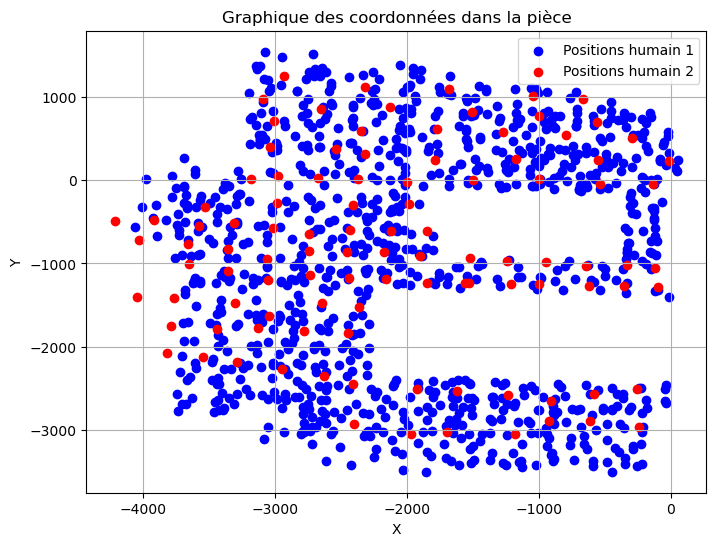

In [53]:
#Superposition des deux 

plt.figure(figsize=(8, 6))

if 'y' in df_centroid_humain1.columns:
    plt.scatter(df_centroid_humain1['x'], df_centroid_humain1['y'], color='blue', label='Positions humain 1')

if 'y' in df_centroid_humain2.columns:
    plt.scatter(df_centroid_humain2['x'], df_centroid_humain2['y'], color='red', label='Positions humain 2')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Graphique des coordonnées dans la pièce')
plt.legend()
plt.grid(True)
plt.show()


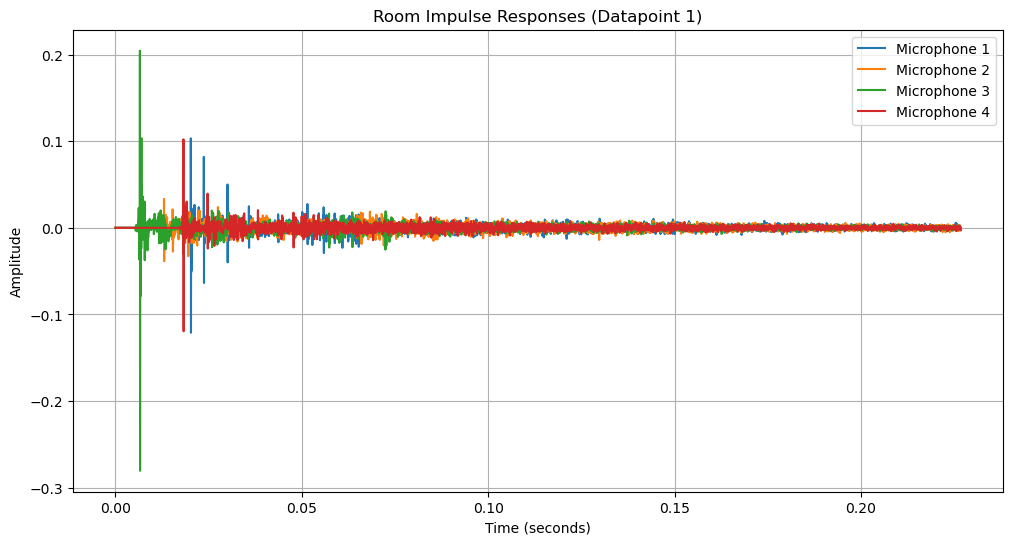

In [ ]:
# Assuming deconvoled_trim is already loaded and has shape [N_datapoints, N_Microphones, N_samples]
N_datapoints, N_Microphones, N_samples = deconvoled_trim.shape

# Choose a specific datapoint and time sample range to plot
datapoint_index = 1  # Choose the datapoint index
time_sample_start = 0  # Start index of time samples
time_sample_end = 10000  # End index of time samples (or choose a specific range)

# Create a time axis for plotting (assuming sampling rate of the RIRs is known)
sampling_rate = 44100  # Example sampling rate (adjust based on your data)
time_axis = np.arange(time_sample_end - time_sample_start) / sampling_rate

# Plot the RIRs for each microphone channel
plt.figure(figsize=(12, 6))
for microphone_index in range(N_Microphones):
    # Extract the RIR for the current microphone channel
    rir = deconvoled_trim[datapoint_index, microphone_index, time_sample_start:time_sample_end]
    
    # Plot the RIR on the same figure with different colors for each microphone
    plt.plot(time_axis, rir, label=f"Microphone {microphone_index + 1}")

plt.title(f"Room Impulse Responses (Datapoint {datapoint_index})")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.legend()
plt.show()


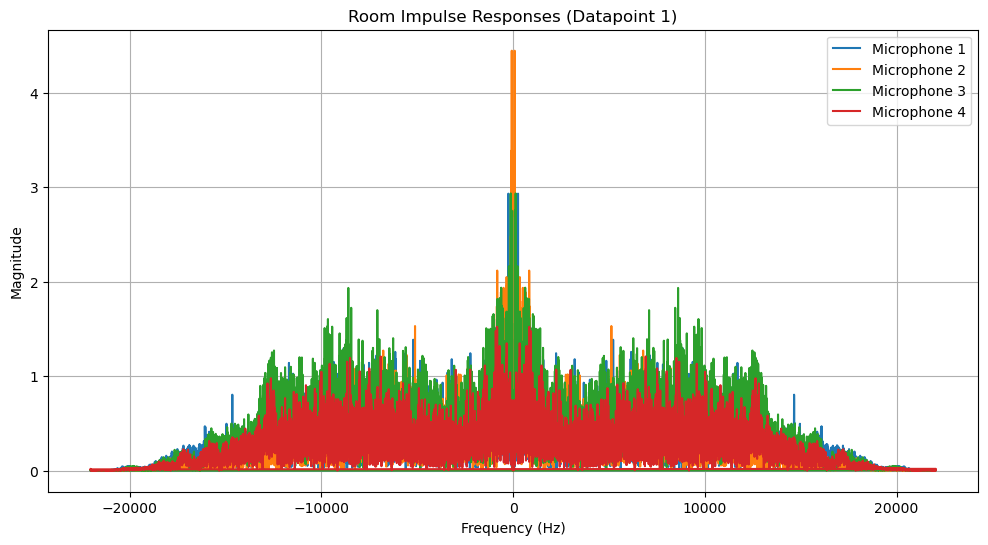

In [12]:
# Plot the RIRs for each microphone channel in the frequency domain
plt.figure(figsize=(12, 6))
for microphone_index in range(N_Microphones):
    # Extract the RIR for the current microphone channel
    rir = deconvoled_trim[datapoint_index, microphone_index, time_sample_start:time_sample_end]
    
    # Compute the FFT
    rir_fft = np.fft.fft(rir)
    
    # Compute the frequency axis
    freq_axis = np.fft.fftfreq(len(rir), 1 / sampling_rate)
    
    # Plot the magnitude of the FFT (absolute value)
    plt.plot(freq_axis, np.abs(rir_fft), label=f"Microphone {microphone_index + 1}")

plt.title(f"Room Impulse Responses (Datapoint {datapoint_index})")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.grid(True)
plt.legend()
plt.show()

#Normalisation
Pas de normalisation sur l'entrée

In [59]:
#Normalization INUTILE ON NE NORMALISE PAS LES TARGET



scaler = StandardScaler()
columns_to_normalize = ['x', 'y']

# Normaliser les données
df_centroid_humain1[columns_to_normalize] = scaler.fit_transform(df_centroid_humain1[columns_to_normalize])


print("Description de Humain 1 après normalisation",df_centroid_humain1.describe())


Description de Humain 1 après normalisation                   x             y
count  1.000000e+03  1.000000e+03
mean   2.557954e-16 -9.947598e-17
std    1.000500e+00  1.000500e+00
min   -1.982209e+00 -1.793387e+00
25%   -7.924082e-01 -1.043751e+00
50%   -9.975152e-02  9.691054e-02
75%    8.753399e-01  8.839608e-01
max    1.890307e+00  1.788670e+00
